In [ ]:
from google.colab import files
uploaded = files.upload()

Saving NLPSampleDataV2.csv to NLPSampleDataV2.csv


In [ ]:
#amma
import tensorflow as tf
#import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
#tf.disable_v2_behavior()
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#!mkdir /Nidhi
#!mkdir /Nidhi/NLP
#!mkdir /Nidhi/NLP/sentence_wise_email
#!mkdir /Nidhi/NLP/sentence_wise_email/module
#!mkdir /Nidhi/NLP/sentence_wise_email/module/module_useT

#!curl -L "https://tfhub.dev/google/universal-sentence-encoder-large/3?tf-hub-format=compressed" | tar -zxvC /Nidhi/NLP/sentence_wise_email/module/module_useT




  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
./
./tfhub_module.pb
./variables/
./variables/variables.data-00000-of-00001
 93  745M   93  698M    0     0  57.8M      0  0:00:12  0:00:12 --:--:-- 58.8M./variables/variables.index
./assets/
./saved_model.pb
100  745M  100  745M    0     0  58.0M      0  0:00:12  0:00:12 --:--:-- 59.6M


In [ ]:
def load_USE_encoder(module):
  with tf.Graph().as_default():
    sentences = tf.placeholder(tf.string)
    embed = hub.Module(module)
    embeddings = embed(sentences)
    session = tf.train.MonitoredSession()
  return lambda x: session.run(embeddings, {sentences: x})

In [ ]:
encoder = load_USE_encoder('/Nidhi/NLP/sentence_wise_email/module/module_useT')

AttributeError: ignored

In [ ]:
messages = [
  "I love pets",
  "I like dogs more than cats.",
  "I once had a bird but it flew away",
  "I like chocolate more than vanilla"
]

In [ ]:
encoded_messages = encoder(messages)

NameError: ignored

In [ ]:
print(encoded_messages)

[[ 0.02097153 -0.07305827  0.05032298 ...  0.02223999 -0.0008878
  -0.02908721]
 [ 0.00121338 -0.03890569  0.03033458 ...  0.05578306  0.01052563
  -0.06047801]
 [ 0.06168427 -0.04696989  0.00278511 ...  0.09244377  0.03892534
  -0.02575566]
 [-0.05640932  0.04837998  0.03628176 ...  0.06111867  0.03426948
  -0.01890007]]


In [ ]:
#cosine similarities
num_messages = len(messages)
similarities_df = pd.DataFrame()
for i in range(num_messages):
  for j in range(num_messages):
    dot_product =np.dot(encoded_messages[i], encoded_messages[j])
    mag_i = np.sqrt(np.dot(encoded_messages[i], encoded_messages[i]))
    mag_j = np.sqrt(np.dot(encoded_messages[j], encoded_messages[j]))

    cos_theta = dot_product / (mag_i * mag_j)

    similarities_df = similarities_df.append(
        {
        'similarity':cos_theta,
        'message1':messages[i],
        'message2':messages[j]
     },
      ignore_index = True
    )

In [ ]:
#convert similarity matrix into dataframe
similarity_heatmap = similarities_df.pivot("message1","message2","similarity")

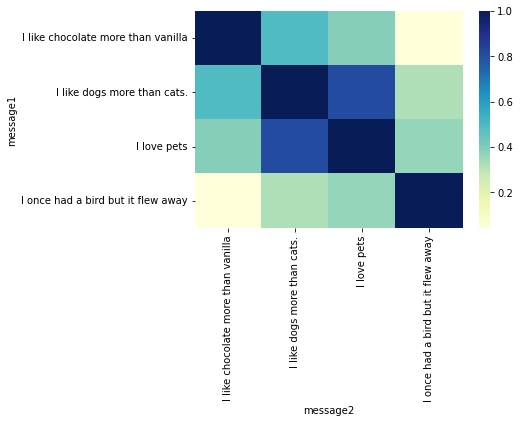

In [ ]:
ax = sns.heatmap(similarity_heatmap, cmap="YlGnBu")
plt.show()

In [ ]:
df = pd.read_csv('NLPSampleDataV2.csv')
train = df[["Replication","Score_replication"]]
print(train)

                                           Replication  Score_replication
0                 it will no influence DNA replication                  1
1    The G to A base change will not affect replica...                  1
2    During DNA replication the entire DNA will be ...                  1
3    In DNA replication the DNA would simply replic...                  1
4    It wont have any direct effect besides that th...                  1
..                                                 ...                ...
555  The stop codon will end up stopping the DNA re...                  3
556  It will stop the replication sooner than was o...                  3
557  Replication will stop and the codon will not b...                  3
558  It will stop the replication and then the DNA ...                  3
559  It will influence DNA replication because ther...                  3

[560 rows x 2 columns]


In [ ]:
train_data = train['Replication']
train_labels = train['Score_replication']


In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
embed = hub.KerasLayer(module_url, trainable=True, name='USE_embedding')

In [ ]:
def build_model(embed):

    model = Sequential([
        Input(shape=[], dtype=tf.string),
        embed,
        Dense(1, activation='sigmoid')
    ])
    model.compile(Adam(2e-5), loss='binary_crossentropy', metrics=['accuracy'])


    return model

In [ ]:
model = build_model(embed)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_embedding (KerasLayer)  (None, 512)               147354880 
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 147,355,393
Trainable params: 147,355,393
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True)

train_history = model.fit(
    train_data, train_labels,
    validation_split=0.25,
    epochs=4,
    callbacks=[checkpoint],
    batch_size=32
)

Epoch 1/4


14/14 [==============================] - 125s 4s/step - loss: 0.6187 - accuracy: 0.3310 - val_loss: 0.1217 - val_accuracy: 0.0000e+00
Epoch 2/4
14/14 [==============================] - 38s 3s/step - loss: 0.3260 - accuracy: 0.4405 - val_loss: -0.5097 - val_accuracy: 0.0000e+00
Epoch 3/4
14/14 [==============================] - 38s 3s/step - loss: 0.0489 - accuracy: 0.4452 - val_loss: -1.1276 - val_accuracy: 0.0000e+00
Epoch 4/4
14/14 [==============================] - 40s 3s/step - loss: -0.2097 - accuracy: 0.4452 - val_loss: -1.6690 - val_accuracy: 0.0000e+00


In [ ]:
model.load_weights('model.h5')
test_pred = model.predict(test_data)

In [ ]:
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)